In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import gymnasium as gym

from astropy.io import fits
from datetime import datetime, timezone
import pandas as pd
import json
import fitsio
import time
import pickle
import re

%reload_ext autoreload
%autoreload 2

In [2]:
import survey_ops
from survey_ops.utils import units, geometry, interpolate
from survey_ops.coreRL.offline_dataset import OfflineDECamDataset
from survey_ops.coreRL.agents import Agent
from survey_ops.algorithms import DDQN, BehaviorCloning
from survey_ops.utils.sys_utils import seed_everything
from survey_ops.coreRL.data_processing import load_raw_data_to_dataframe


In [3]:
from survey_ops.utils import ephemerides
from tqdm import tqdm
from pathlib import Path

In [4]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from collections import Counter
from scipy.stats import entropy

In [5]:
SEED = 10
seed_everything(SEED)
torch.set_default_dtype(torch.float32)
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

# Load config and lookup files

In [6]:
with open('../configs/global_config.json', 'r') as f:
    glob_cfg = json.load(f)

In [9]:
with open('../experiment_results/ra_config.json', 'r') as f:
    cfg_radec = json.load(f)

In [10]:
# with open(glob_cfg.get('paths.lookup_dir') + '/' + cfg.get('paths')['FIELD2NVISITS'], 'r') as f:
#     field2nvisits = json.load(f)
# with open(glob_cfg.get('paths.lookup_dir') + '/' + cfg.get('paths')['FIELD2NAME'], 'r') as f:
#     field2name = json.load(f)
# with open(glob_cfg.get('paths.lookup_dir') + '/' + cfg.get('paths')['FIELD2RADEC'], 'r') as f:
#     field2radec = json.load(f)
with open('../data/lookups/nside16_bin2azel.json', 'r') as f:
    bin2azel = json.load(f)
with open('../data/lookups/nside16_bin2radec.json', 'r') as f:
    bin2radec = json.load(f)


# Load Will's fields list

In [11]:
with open('../data/sample_schedule_20251108_00_10_00.json', 'r') as f:
    sample_fields_list = json.load(f)

In [12]:
fields_df = pd.DataFrame(sample_fields_list)

Text(0, 0.5, 'dec (deg)')

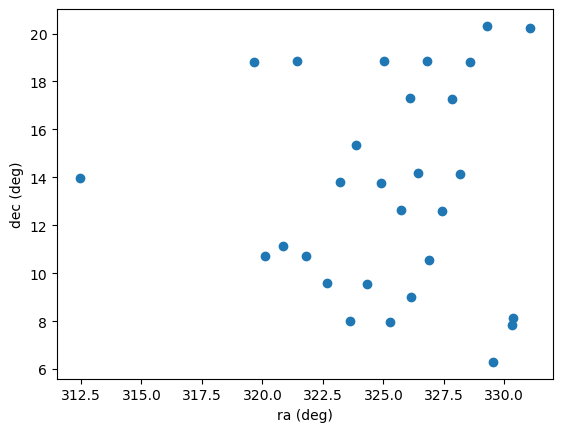

In [13]:
plt.scatter(fields_df['RA'], fields_df['dec'])
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')

In [26]:
from datetime import datetime, timezone

In [19]:
fields_df['field_id'] = pd.factorize(fields_df['object'])[0]


In [25]:
# First get test night sunrise and sunset timestamps
    # TODO: use get_nautical_twilight()
    # For now, just set it to 23:00 on June 21st
dt = datetime(2026, 6, 23, 0, 0, 0, tzinfo=timezone.utc)

In [36]:
dt.year

2026

In [38]:
pd.Timestamp(dt).timestamp()

1782172800.0

In [31]:
dt.time() = 23, 10

SyntaxError: cannot assign to function call here. Maybe you meant '==' instead of '='? (2371506648.py, line 1)

In [27]:
dt.date()

datetime.date(2026, 6, 23)

In [34]:
# Get zenith at t0
blanco = ephemerides.blanco_observer(time=t0)

In [ ]:
# To get environment started, need to supply zenith state and per-bin states

def get_zenith_state(year, month, day, hour, minute, sec, t_sunrise, t_sunset):
    datetime = datetime(year, month, day, hour, minute, sec, tzinfo=timezone.utc)
    night = datetime(year, month, day, tzinfo=timezone.utc)
    t0 = datetime.timestamp()
    blanco = ephemerides.blanco_observer(time=t0)

    zenith = {}
    zenith['ra'], zenith['dec'] = blanco.lat, blanco.lon
    zenith['az'], zenith['el'] = 0, np.pi/2
    zenith['airmass'] = 1
    zenith['ha'] = 0
    zenith['object'] = 'zenith'
    zenith['field_id'] = -1
    zenith['bin'] = -1
    zenith['datetime'] = datetime
    zenith['night'] = night
    zenith['sun_ra'], zenith['sun_dec'] = ephemerides.get_source_ra_dec(source='sun', time=t0)
    zenith['sun_az'], zenith['sun_el'] = ephemerides.equatorial_to_topographic(ra=zenith['sun_ra'], dec=zenith['sun_dec'], time=t0)
    zenith['moon_ra'], zenith['moon_dec'] = ephemerides.get_source_ra_dec(source='moon', time=t0)
    zenith['moon_az'], zenith['moon_el'] = ephemerides.equatorial_to_topographic(ra=zenith['moon_ra'], dec=zenith['moon_dec'], time=t0)
    zenith['time_fraction_since_start'] = (t0 - t_sunset) / (t_sunrise - t_sunset)

def get_zenith_bins_states(year, month, day, hour, minute, sec):
    